In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import numpy as np
import time
from torchvision.transforms import ToPILImage
show = ToPILImage()

In [3]:
import torch.nn.functional as F

In [4]:
import torch.optim as optim

In [5]:
# 数据预处理，相当于提前定义了怎么处理数据：
# 因为读入的数据为numpy格式，所以我们要先将其转换为tensor格式，
# 然后对其进行归一化，有三个通道需要归一化，而第一个为均值，第二个为标准差
transform = transforms.Compose([
    transforms.ToTensor(), # 转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 训练集
trainset = tv.datasets.CIFAR10(
    root='/kaggle/input/cifar10-python',
    train=True,
    download=False,
    transform=transform
)

# 迭代器
trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,
    num_workers=16,
    pin_memory=True
)

# 测试集
testset = tv.datasets.CIFAR10(
    root='/kaggle/input/cifar10-python',
    train=False,
    download=False,
    transform=transform
)

# 迭代器
testloader = t.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=False,
    num_workers=16,
    pin_memory=True
)
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

ship


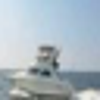

In [6]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

cat       deer       truck       cat       ship       deer       ship       cat       horse       car       horse       bird       cat       truck       truck       plane       ship       bird       dog       bird       cat       frog       dog       cat       truck       cat       deer       dog       deer       ship       plane       cat       cat       dog       car       horse       car       ship       ship       plane       ship       truck       horse       dog       deer       dog       plane       plane       dog       dog       plane       deer       dog       car       dog       horse       cat       car       truck       ship       dog       plane       frog       deer


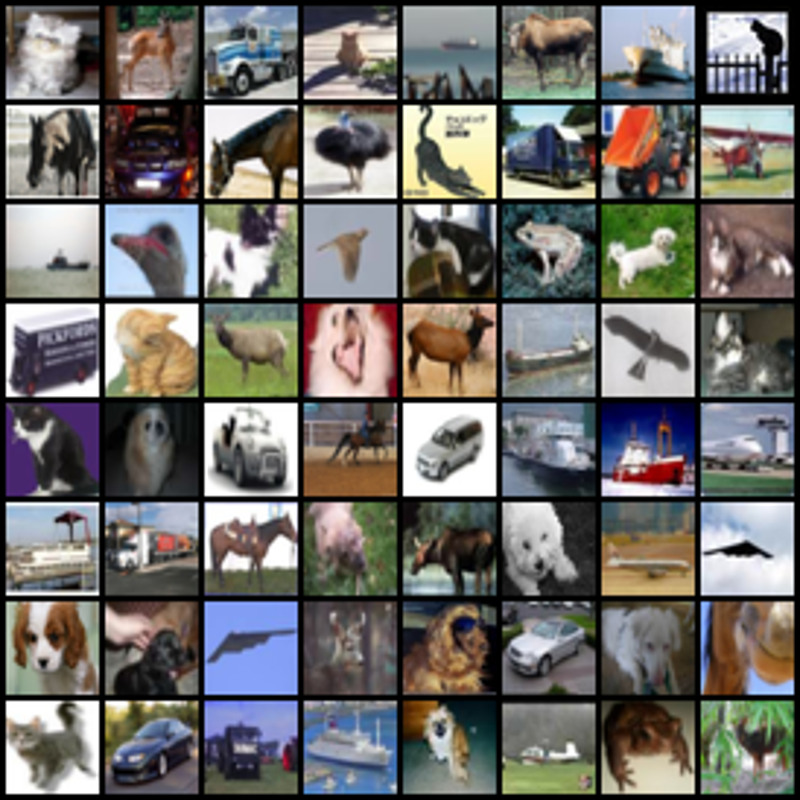

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('       '.join(classes[labels]))
show(tv.utils.make_grid((images + 1) / 2)).resize((800, 800))

In [8]:
# LeNet
class LeNet(nn.Module):
    
    def __init__(self) -> None:
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

lenet = LeNet()
print(lenet)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
# AlexNet
NUM_CLASSES = 10

class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),   # (32 + 1*2 - 3) / 2 + 1 = 16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                        # (16 + 0 * 2 - 2) / 2  + 1 = 8
            nn.Conv2d(64, 192, kernel_size=3, padding=1),    # (8 + 1 * 2 - 3) / 1 + 1 = 8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),    # (8 + 0 * 2 - 2) / 2 + 1 = 4
            nn.Conv2d(192, 384, kernel_size=3, padding=1),   # (4 + 1 * 2 - 3) / 1 + 1 = 4
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),   # (4 + 1 * 2 - 3) / 1 + 1 = 4
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),   # (4 + 1 * 2 - 3) / 1 + 1 = 4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),    # (4 + 0 * 2 - 2) / 2 + 1 = 2
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)   # 变换Tensor形状
        x = self.classifier(x)
        return x

alexnet = AlexNet()
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [10]:

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def VGG11():
    return VGG('VGG11')


def VGG13():
    return VGG('VGG13')


def VGG16():
    return VGG('VGG16')


def VGG19():
    return VGG('VGG19')




In [11]:
vgg11, vgg13, vgg16, vgg19 = VGG11(), VGG13(),VGG16(), VGG19()
print(list(vgg11.parameters()))

[Parameter containing:
tensor([[[[-0.1410,  0.0370, -0.0174],
          [-0.0457,  0.0663, -0.0662],
          [ 0.0810,  0.0922, -0.1163]],

         [[-0.1190, -0.0014,  0.0651],
          [-0.1125,  0.1620, -0.1454],
          [-0.1903,  0.0508,  0.1357]],

         [[ 0.0202, -0.0546, -0.1836],
          [-0.0723,  0.1271,  0.0782],
          [ 0.0137, -0.1881, -0.0629]]],


        [[[-0.0014,  0.0091, -0.0760],
          [-0.1765, -0.0518, -0.0621],
          [ 0.0293, -0.0878,  0.0572]],

         [[-0.1481,  0.0560, -0.1646],
          [ 0.0985, -0.1743, -0.1566],
          [ 0.0482, -0.1103,  0.1758]],

         [[ 0.1730,  0.1739,  0.0874],
          [ 0.0319,  0.1723, -0.1363],
          [ 0.0053,  0.0058, -0.0036]]],


        [[[ 0.1583, -0.1211,  0.0909],
          [ 0.1428,  0.0229,  0.0863],
          [ 0.0354, -0.0779, -0.0294]],

         [[ 0.0565,  0.1588,  0.0732],
          [ 0.0410,  0.1841,  0.0156],
          [-0.0625, -0.1712,  0.1269]],

         [[-0.0377,  

In [12]:
# GoogLeNet
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return t.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [13]:
googlenet = GoogLeNet()

In [14]:
# 定义优化器和损失函数
# optimizer = optim.Adam  # 这个到训练时再定义。
criterion = nn.CrossEntropyLoss()

In [15]:
# move the input and model to GPU for speed if available
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

In [16]:
print(device)

cuda:0


In [32]:
# list_all = [lenet, alexnet, vgg11, vgg13, vgg16, vgg19, googlenet]
# list_all_name = ['LeNet', 'AlexNet', 'VGG11', 'VGG13', 'VGG16', 'VGG19', 'GoogLeNet']
# list_all = [lenet]
# list_all_name = ['LeNet']
# list_all = [alexnet]
# list_all_name = ['AlexNet']
# list_all = [vgg13]
# list_all_name = ['VGG13']
# list_all = [vgg16]
# list_all_name = ['VGG16']
# list_all = [vgg19]
# list_all_name = ['VGG19']
list_all = [googlenet]
list_all_name = ['GoogLeNet']

In [33]:
for name, net in zip(list_all_name, list_all):
    print('model:',name , 'params:', len(list(net.parameters())))

model: GoogLeNet params: 258


In [34]:
for net in list_all:
    net.to(device)

In [35]:
# 训练网络
all_time = {}   # 用来装每一个类别20次epoch分别花费的时间
all_loss = {}   # 用来装每一个类别20次epoch每次epoch的loss
sort_accuracy = {}# 用来装最后一次epoch后，也即训练完成后，10类物体每一类的模型测试准确率
accuracy = {}# 用来装每个模型，20次epoch每一次的测试集准确率

for net_name, net in zip(list_all_name, list_all):
    
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    all_time[net_name] = []   # 用来装每一个类别20次epoch分别花费的时间
    all_loss[net_name] = []  # 用来装每一个类别20次epoch每次epoch的loss
    sort_accuracy[net_name] = [] # 用来装最后一次epoch后，也即训练完成后，10类物体每一类的模型测试准确率
    accuracy[net_name] = []  # 用来装每个模型，20次epoch每一次的测试集准确率

    for epoch in range(20):   # loop over the dataset multiple times
        
        start_time = time.time()
        running_loss = []
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = net(inputs)
            loss = criterion(output, labels)
            running_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        
        # Time
        end_time = time.time()
        time_taken = end_time - start_time
        all_time[net_name].append(time_taken)

        # loss
        all_loss[net_name].append(np.mean(running_loss))

        #Testing Accuracy
        correct = 0
        total = 0
        with t.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = t.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy[net_name].append(correct / total)

        # Every Sort accuracy
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with t.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = t.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        sort_accuracy[net_name] = [class_correct[i] / class_total[i] for i in range(10)]

    
    print(f'Finished Training of {net_name}, time spent: {sum(all_time[net_name])}s, Testing Accuracy:{accuracy[net_name][-1]}')

Finished Training of GoogLeNet, time spent: 3150.098709821701s, Testing Accuracy:0.98292


#### 这个是lenet

In [ ]:
print(all_loss)

In [ ]:
print(accuracy)

In [ ]:
print(sort_accuracy)

## 这个是vgg11

In [ ]:
print(all_loss)
print(accuracy)
print(sort_accuracy)

## 这才是 AlexNet!! 楼上是VGG11!!! 

In [ ]:
print(all_loss)
print(accuracy)
print(sort_accuracy)

## 这个是VGG13

In [21]:
print(all_loss)
print(accuracy)
print(sort_accuracy)

{'VGG13': [1.2642371852684509, 0.7722501971989947, 0.5903376623264054, 0.4784044684923213, 0.3800432443847437, 0.30268731431278123, 0.23576976750951137, 0.18087512682027676, 0.1408744841037542, 0.10939275374864717, 0.08912606567770834, 0.07885368761744664, 0.0641673685397174, 0.059465244257598734, 0.05032006161191555, 0.05069959139102436, 0.0446176283173007, 0.04227883966442089, 0.038349986351278245, 0.035195458980138435]}
{'VGG13': [0.6891, 0.77314, 0.83566, 0.88822, 0.90306, 0.92948, 0.93804, 0.96178, 0.97378, 0.97418, 0.97518, 0.98266, 0.98802, 0.9846, 0.98568, 0.98912, 0.99238, 0.9936, 0.99396, 0.98878]}
{'VGG13': [0.9857142857142858, 0.9910714285714286, 0.9846153846153847, 0.9775641025641025, 0.9801980198019802, 0.9935275080906149, 0.9819819819819819, 0.9933110367892977, 0.9866220735785953, 1.0]}


## VGG16

In [26]:
print(all_loss)
print(accuracy)
print(sort_accuracy)

{'VGG16': [1.4878040287653198, 0.9365591992959952, 0.7370820180763065, 0.6060846281783355, 0.5078294051958777, 0.4291884641894294, 0.3603880833024564, 0.2933719548994623, 0.24789767926725584, 0.198568012527264, 0.1621592563060124, 0.1343770895839271, 0.11871750627541938, 0.0996952341926639, 0.08778401462586306, 0.0753310109254049, 0.06421501902134522, 0.06112010521195529, 0.0573385018331911, 0.0516717257278869]}
{'VGG16': [0.61826, 0.72454, 0.79506, 0.81732, 0.84844, 0.88578, 0.90558, 0.92866, 0.93832, 0.9508, 0.95308, 0.96834, 0.97676, 0.95392, 0.98222, 0.98524, 0.98964, 0.98392, 0.98868, 0.98892]}
{'VGG16': [0.9821428571428571, 1.0, 0.9907692307692307, 0.9871794871794872, 0.9966996699669967, 0.9935275080906149, 0.993993993993994, 0.9832775919732442, 0.9899665551839465, 1.0]}


## VGG19

In [31]:
print(all_loss)
print(accuracy)
print(sort_accuracy)

{'VGG19': [1.7686422246191509, 1.193289189539907, 0.9002916185599764, 0.7483896711826934, 0.6286251023221199, 0.5321085340417254, 0.4624791795297352, 0.38920851096587106, 0.33552453419684297, 0.2911587263483678, 0.24505771608913646, 0.20557330978696076, 0.1741280048142385, 0.14644487293513345, 0.1290046954908601, 0.11228246268544756, 0.09866908017803183, 0.08531898694664307, 0.08279588602601176, 0.0675076813722277]}
{'VGG19': [0.4279, 0.66604, 0.7312, 0.77616, 0.82448, 0.84562, 0.87258, 0.90588, 0.9072, 0.93078, 0.94332, 0.95704, 0.95202, 0.9642, 0.97252, 0.9682, 0.97178, 0.97656, 0.97264, 0.98384]}
{'VGG19': [0.9964285714285714, 0.9821428571428571, 0.9723076923076923, 0.9166666666666666, 0.9933993399339934, 0.9805825242718447, 0.984984984984985, 0.9899665551839465, 0.9966555183946488, 1.0]}


## GoogLeNet

In [36]:
print(all_loss)
print(accuracy)
print(sort_accuracy)

{'GoogLeNet': [1.2311952696431934, 0.7666956804063924, 0.578668496149885, 0.4777612447205102, 0.3925454377594506, 0.3375073971079134, 0.2815402130908368, 0.23534502303394514, 0.19595492798406297, 0.16418727704554872, 0.14072739037082477, 0.11543235368431186, 0.10002748314839076, 0.08524505978824137, 0.08325784758050138, 0.06983265248925218, 0.06453105599111508, 0.058409628307665974, 0.05595131519743625, 0.05454142128511587]}
{'GoogLeNet': [0.68024, 0.78884, 0.84078, 0.87326, 0.88924, 0.90944, 0.92276, 0.93896, 0.94442, 0.95026, 0.9642, 0.96864, 0.97296, 0.97084, 0.97456, 0.97932, 0.98056, 0.98624, 0.98712, 0.98292]}
{'GoogLeNet': [0.9892857142857143, 0.9970238095238095, 0.9723076923076923, 0.967948717948718, 0.9834983498349835, 0.970873786407767, 0.996996996996997, 0.9899665551839465, 0.9933110367892977, 0.9879518072289156]}
